### 1. Memuat dan periksa data

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind, pearsonr
import numpy as np
import pickle

Load data

In [86]:
df = pd.read_csv("./ai_dev_productivity.csv")

Mengecek data benar dengan 5 baris pertama

In [87]:

print(df.head())

   hours_coding  coffee_intake_mg  distractions  sleep_hours  commits  \
0          5.99               600             1          5.8        2   
1          4.72               568             2          6.9        5   
2          6.30               560             1          8.9        2   
3          8.05               600             7          6.3        9   
4          4.53               421             6          6.9        4   

   bugs_reported  ai_usage_hours  cognitive_load  task_success  
0              1            0.71             5.4             1  
1              3            1.75             4.7             1  
2              0            2.27             2.2             1  
3              5            1.40             5.9             0  
4              0            1.26             6.3             1  


Mengecek statistik deskriptif tiap column

In [88]:
df["productivity_score"] = (0.5 * df["commits"] + 0.3 * df["task_success"] - 0.2 * df["bugs_reported"])

Mengecek missing values

In [89]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 hours_coding          0
coffee_intake_mg      0
distractions          0
sleep_hours           0
commits               0
bugs_reported         0
ai_usage_hours        0
cognitive_load        0
task_success          0
productivity_score    0
dtype: int64


### 2. Mendefinisikan fitur dan target dari data

In [90]:
X = df[["ai_usage_hours", "sleep_hours", "coffee_intake_mg", "cognitive_load", "distractions"]]
y = df["productivity_score"]  # or "commits"

### 3. Exploratory Data Analysis (EDA)

Mencari hubungan antara fitur dan target

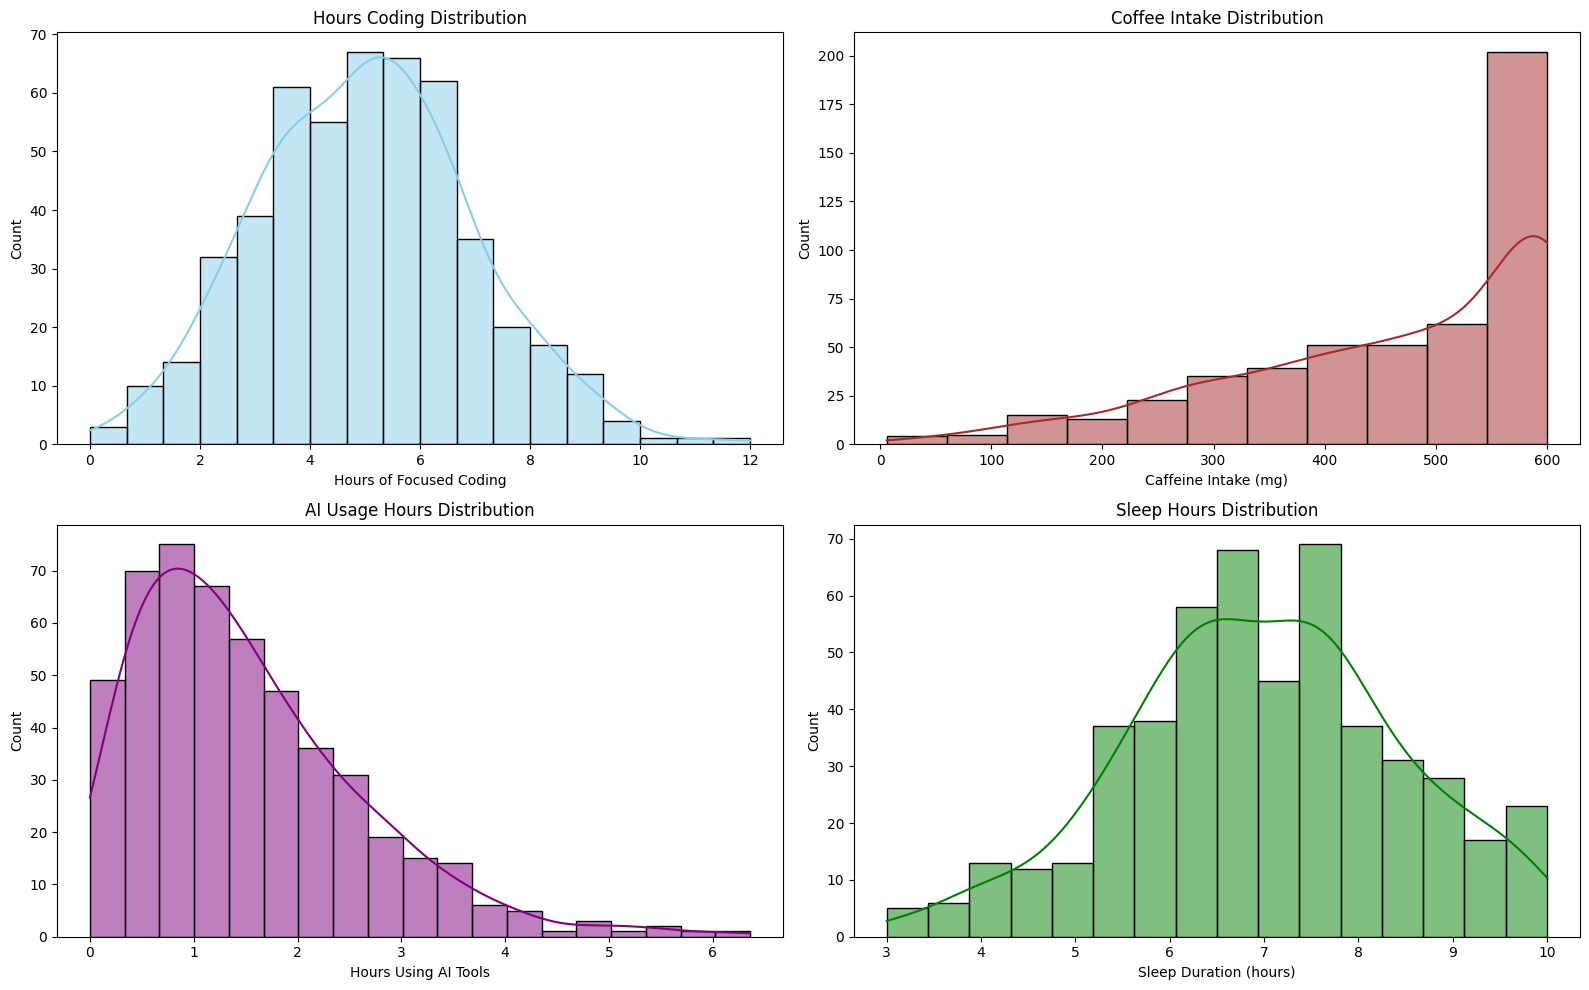

In [91]:
# --- Subplots: Distribution of Key Features ---
# This grid of histograms shows the distribution of productivity and physiological variables.
# It helps in understanding the range, skewness, and potential anomalies in each feature.

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# hours_coding
sns.histplot(df['hours_coding'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Hours Coding Distribution')
axes[0, 0].set_xlabel('Hours of Focused Coding')

# coffee_intake_mg
sns.histplot(df['coffee_intake_mg'], kde=True, ax=axes[0, 1], color='brown')
axes[0, 1].set_title('Coffee Intake Distribution')
axes[0, 1].set_xlabel('Caffeine Intake (mg)')

# ai_usage_hours
sns.histplot(df['ai_usage_hours'], kde=True, ax=axes[1, 0], color='purple')
axes[1, 0].set_title('AI Usage Hours Distribution')
axes[1, 0].set_xlabel('Hours Using AI Tools')

# sleep_hours
sns.histplot(df['sleep_hours'], kde=True, ax=axes[1, 1], color='green')
axes[1, 1].set_title('Sleep Hours Distribution')
axes[1, 1].set_xlabel('Sleep Duration (hours)')

plt.tight_layout()
plt.show()

Identifikasi variabel mana yang memiliki hubungan kuat dengan hasil produktivitas.

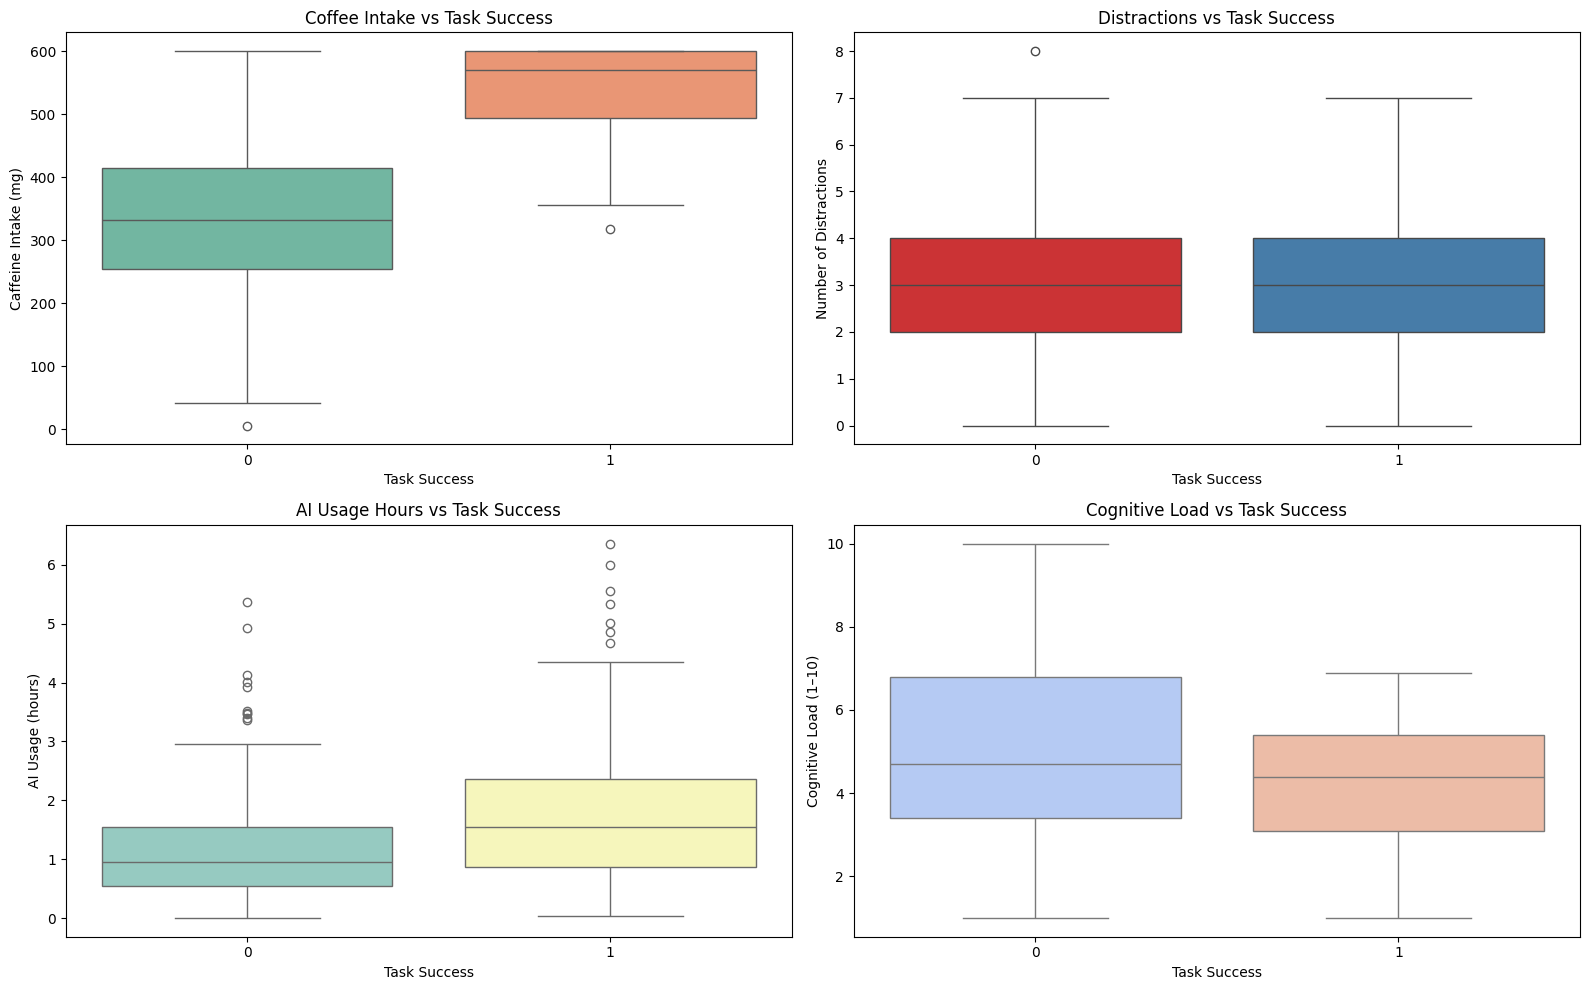

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# coffee_intake_mg vs task_success
sns.boxplot(x='task_success', y='coffee_intake_mg', data=df, ax=axes[0, 0], 
            hue='task_success', palette='Set2', legend=False)
axes[0, 0].set_title('Coffee Intake vs Task Success')
axes[0, 0].set_xlabel('Task Success')
axes[0, 0].set_ylabel('Caffeine Intake (mg)')

# distractions vs task_success
sns.boxplot(x='task_success', y='distractions', data=df, ax=axes[0, 1], 
            hue='task_success', palette='Set1', legend=False)
axes[0, 1].set_title('Distractions vs Task Success')
axes[0, 1].set_xlabel('Task Success')
axes[0, 1].set_ylabel('Number of Distractions')

# ai_usage_hours vs task_success
sns.boxplot(x='task_success', y='ai_usage_hours', data=df, ax=axes[1, 0], 
            hue='task_success', palette='Set3', legend=False)
axes[1, 0].set_title('AI Usage Hours vs Task Success')
axes[1, 0].set_xlabel('Task Success')
axes[1, 0].set_ylabel('AI Usage (hours)')

# cognitive_load vs task_success
sns.boxplot(x='task_success', y='cognitive_load', data=df, ax=axes[1, 1], 
            hue='task_success', palette='coolwarm', legend=False)
axes[1, 1].set_title('Cognitive Load vs Task Success')
axes[1, 1].set_xlabel('Task Success')
axes[1, 1].set_ylabel('Cognitive Load (1–10)')

plt.tight_layout()
plt.show()

Melihat korelasi antar variabel dengan Heatmap

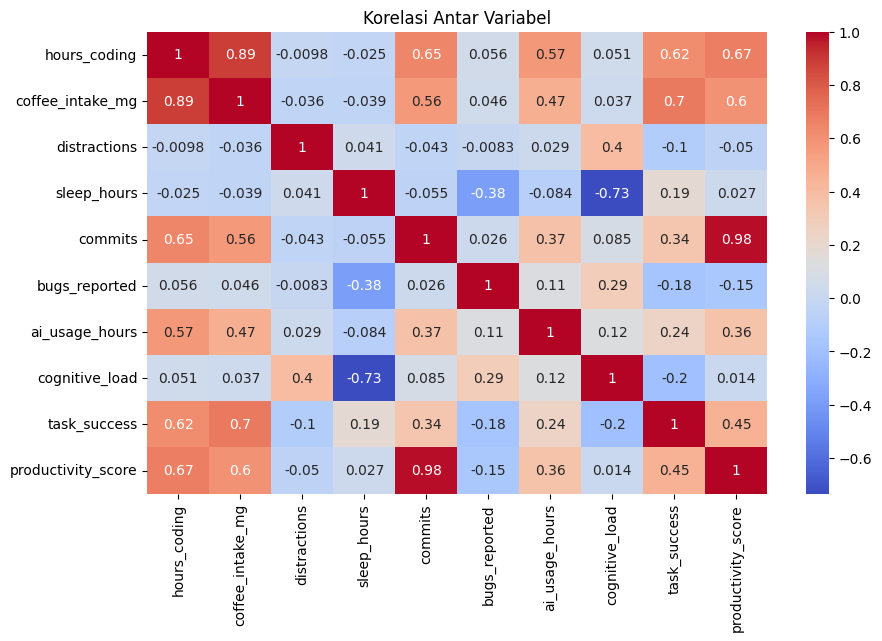

In [93]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Korelasi Antar Variabel")
plt.show()

Mengeksplorasi hubungan antara pasangan variabel untuk potensi prediksi interaksi

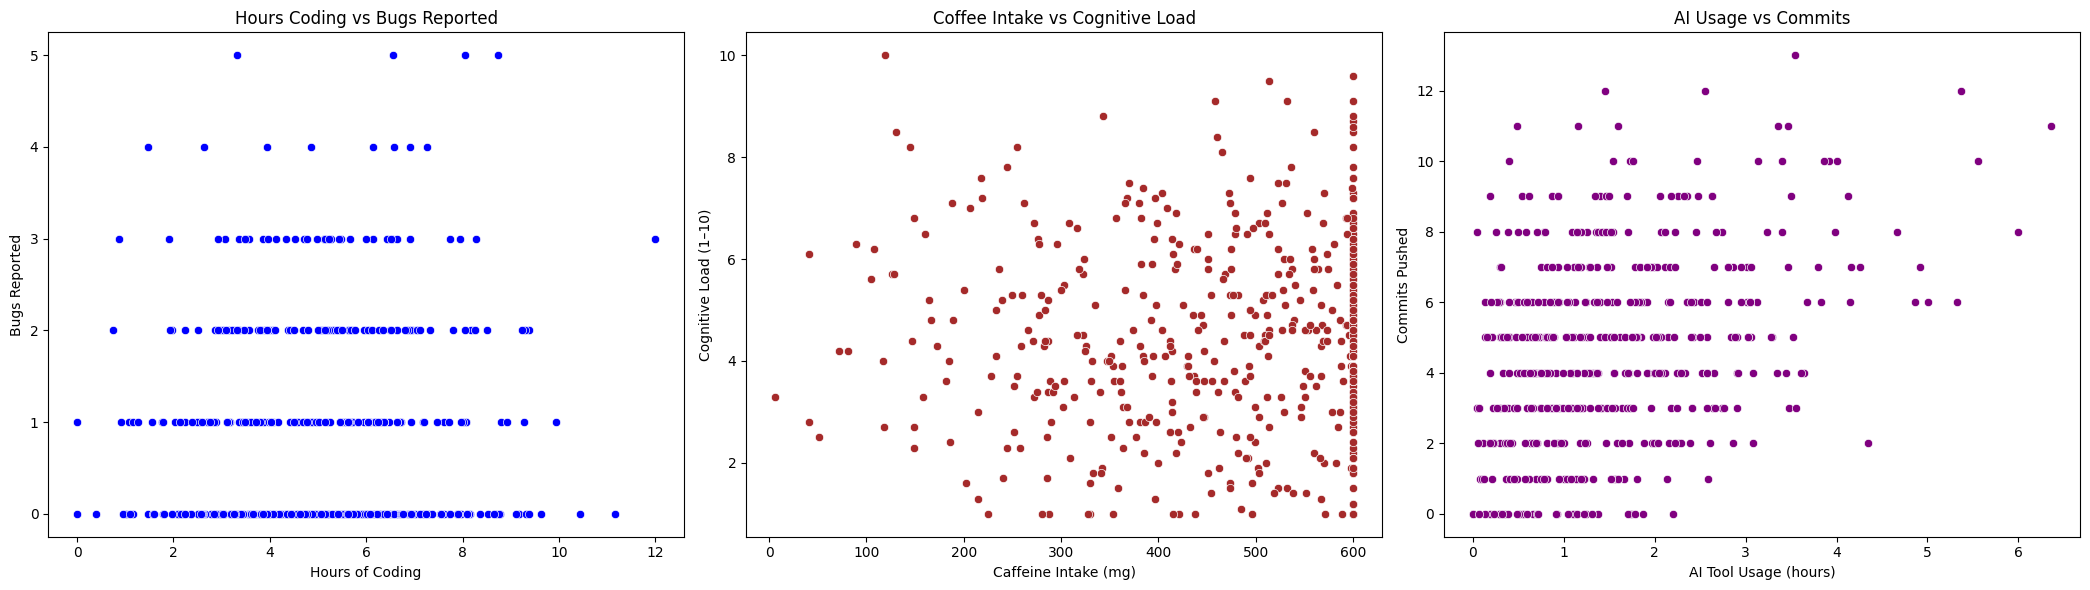

In [94]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# hours_coding vs bugs_reported
sns.scatterplot(x='hours_coding', y='bugs_reported', data=df, ax=axes[0], color='blue')
axes[0].set_title('Hours Coding vs Bugs Reported')
axes[0].set_xlabel('Hours of Coding')
axes[0].set_ylabel('Bugs Reported')

# coffee_intake_mg vs cognitive_load
sns.scatterplot(x='coffee_intake_mg', y='cognitive_load', data=df, ax=axes[1], color='brown')
axes[1].set_title('Coffee Intake vs Cognitive Load')
axes[1].set_xlabel('Caffeine Intake (mg)')
axes[1].set_ylabel('Cognitive Load (1–10)')

# ai_usage_hours vs commits
sns.scatterplot(x='ai_usage_hours', y='commits', data=df, ax=axes[2], color='purple')
axes[2].set_title('AI Usage vs Commits')
axes[2].set_xlabel('AI Tool Usage (hours)')
axes[2].set_ylabel('Commits Pushed')

plt.tight_layout()
plt.show()

Memeriksa keseimbangan kelas sebelum klasifikasi

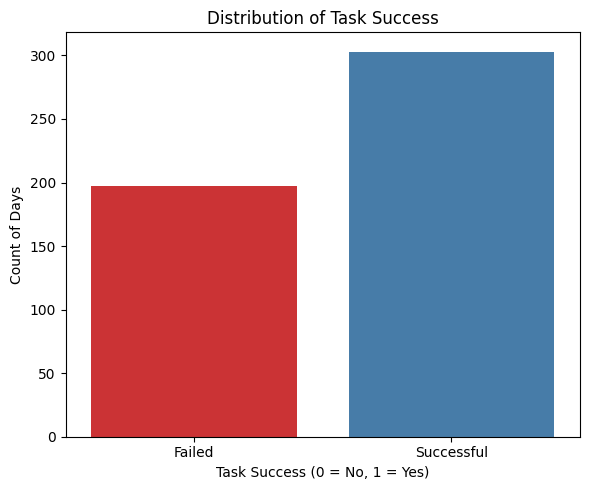

In [95]:
plt.figure(figsize=(6, 5))
sns.countplot(x='task_success', data=df, hue='task_success', palette='Set1', legend=False)
plt.title('Distribution of Task Success')
plt.xlabel('Task Success (0 = No, 1 = Yes)')
plt.ylabel('Count of Days')
plt.xticks([0, 1], ['Failed', 'Successful'])
plt.tight_layout()
plt.show()

### 4. Preprocessing Data

Mengisi missing values dengan median

In [96]:
X = X.fillna(X.median())

Menormalisasi data ke skala standar

In [97]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 5. Melatih model 

#### Clasifier (Random Forest Classifier)

Membuat target biner (1=Produktivitas Tinggi, 0=Rendah)

R² Score: -0.09

Feature Importance:
             Feature  Importance
1  coffee_intake_mg    0.311100
5    cognitive_load    0.222701
0    ai_usage_hours    0.159640
3       sleep_hours    0.152959
2      distractions    0.100114
4     bugs_reported    0.053487


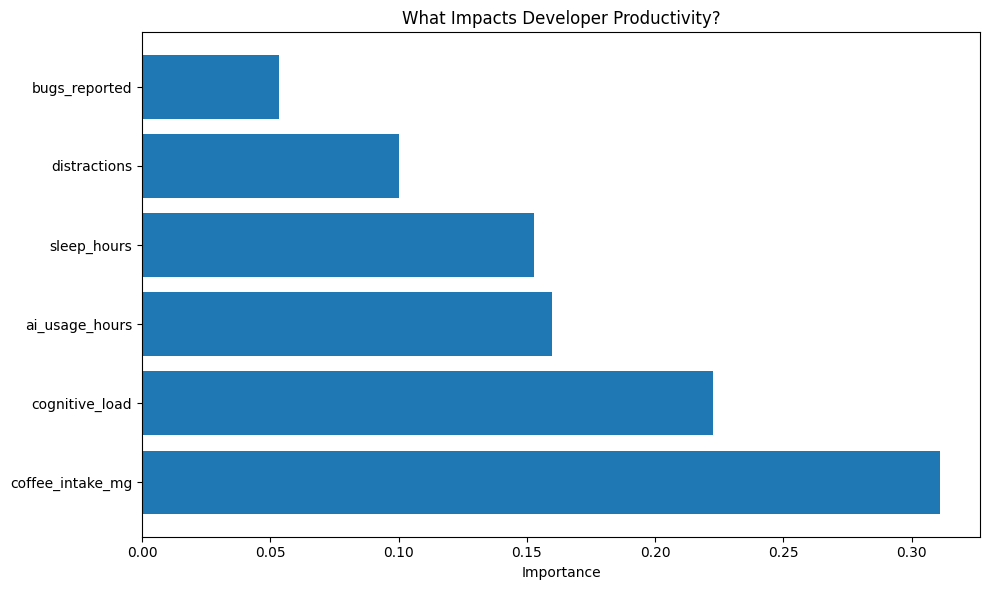


Avg Productivity: 0.93 commits/hour


In [98]:
# Calculate productivity (commits/hour) with NaN handling
df['productivity_score'] = df.apply(
    lambda row: row['commits'] / (row['hours_coding'] + 1e-6) if row['hours_coding'] != 0 
    else np.nan, axis=1
)

# Remove rows with NaN in productivity_score (alternative to adding small constant)
df = df.dropna(subset=['productivity_score'])

# --- Model: Predict Productivity Based on AI Usage ---
X = df[['ai_usage_hours', 'coffee_intake_mg', 'distractions', 'sleep_hours', 'bugs_reported', 'cognitive_load']]
y = df['productivity_score']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")  # Closer to 1 = better fit

# --- Feature Importance: Does AI Boost Productivity? ---
importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nFeature Importance:\n", feature_importance)

# Plot importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title("What Impacts Developer Productivity?")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

ai_users = df[df['ai_usage_hours'] > 0]['productivity_score']
print(f"\nAvg Productivity: {ai_users.mean():.2f} commits/hour")

In [114]:
with open('model_classifier_productivity.pkl', 'wb') as file:
    pickle.dump(model, file)

In [99]:
corr, p_value = pearsonr(df['ai_usage_hours'], df['commits'])
print(f"Correlation (AI Usage vs. Commits): {corr:.2f}, p-value: {p_value:.3f}")

Correlation (AI Usage vs. Commits): 0.36, p-value: 0.000


In [100]:
df['ai_cognitive_interaction'] = df['ai_usage_hours'] * df['cognitive_load']

#### Regresi

Menggunakan metode regresi untuk mencari tingkat produktifitas berdasarkan task success

In [101]:
# Define feature columns 
X = df[['ai_usage_hours', 'hours_coding', 'sleep_hours', 'distractions', 'coffee_intake_mg', 'cognitive_load']]
y = df['task_success']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

rf_regressor.score(X, y)

# Make predictions
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.008188000000000003
R-squared Score: 0.9640087912087912


In [113]:
with open('model_regression_productivity.pkl', 'wb') as file:
    pickle.dump(rf_regressor, file)

#### Clustering (K-Means)

Menggunakan K-Means untuk mengelompokan data

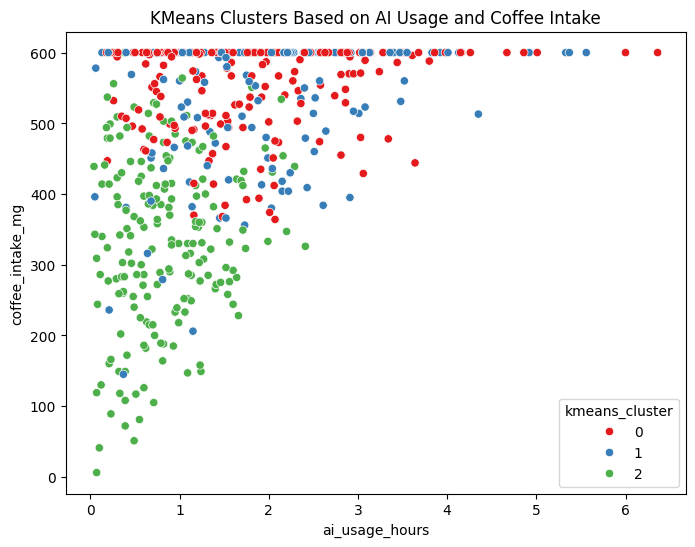

In [ ]:

# Scale features
X = df[['ai_usage_hours', 'coffee_intake_mg', 'distractions', 'sleep_hours', 'commits', 'bugs_reported']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Plot the KMeans clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='ai_usage_hours', y='coffee_intake_mg', hue='kmeans_cluster', data=df, palette='Set1')
plt.title('KMeans Clusters Based on AI Usage and Coffee Intake')
plt.show()

In [116]:
with open('model_clustering_productivity.pkl', 'wb') as file:
    pickle.dump(rf_regressor, file)

Membagi data menjadi 2 kelompok berdasarkan penggunaan AI

In [103]:
median_ai = df["ai_usage_hours"].median()

# 1. Kelompok dengan penggunaan AI di atas median
high_ai = df[df["ai_usage_hours"] > median_ai]["productivity_score"]

# 2. Kelompok dengan penggunaan AI di bawah atau sama dengan median 
low_ai = df[df["ai_usage_hours"] <= median_ai]["productivity_score"]

# Melakukan independent t-test untuk membandingkan produktivitas kedua kelompok
t_stat, p_value = ttest_ind(high_ai, low_ai)

print(f"T-test p-value: {p_value:.3f}")

T-test p-value: 0.758


### 6. Visualisasi Data

#### 1. Dampak Penggunaan AI pada Produktivitas Developer

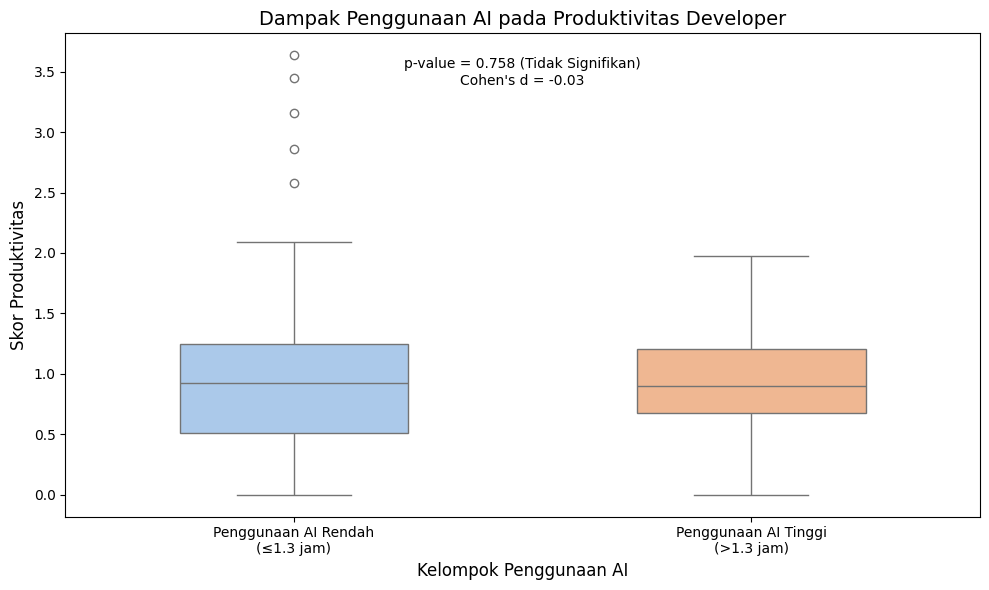

Hasil Analisis:
- Rata-rata produktivitas kelompok High AI: 0.92
- Rata-rata produktivitas kelompok Low AI: 0.93
- Perbedaan: -0.01 poin
- Effect size (Cohen's d): -0.03
- Signifikansi statistik: Tidak signifikan


In [104]:
# Hitung Cohen's d
def cohens_d(a, b):
    n1, n2 = len(a), len(b)
    pooled_std = np.sqrt(((n1-1)*np.std(a, ddof=1)**2 + (n2-1)*np.std(b, ddof=1)**2) / (n1 + n2 - 2))
    return (np.mean(a) - np.mean(b)) / pooled_std

d = cohens_d(high_ai, low_ai) 

# Uji t-test
t_stat, p_value = ttest_ind(high_ai, low_ai)

# Visualisasi
plt.figure(figsize=(10, 6))
sns.boxplot(
    x=df["ai_usage_hours"] > median_ai,
    y=df["productivity_score"],
    hue=df["ai_usage_hours"] > median_ai,
    palette="pastel",
    width=0.5,
    legend=False
)

plt.xticks(
    [False, True],
    [f"Penggunaan AI Rendah\n(≤{median_ai:.1f} jam)", 
     f"Penggunaan AI Tinggi\n(>{median_ai:.1f} jam)"]
)
plt.xlabel("Kelompok Penggunaan AI", fontsize=12)
plt.ylabel("Skor Produktivitas", fontsize=12)
plt.title("Dampak Penggunaan AI pada Produktivitas Developer", fontsize=14)

# Tambahkan anotasi statistik
if p_value < 0.05:
    effect_size = "kecil" if abs(d) < 0.5 else "sedang" if abs(d) < 0.8 else "besar"
    plt.text(0.5, 0.95, 
             f"p-value = {p_value:.3f}*\nCohen's d = {d:.2f} (efek {effect_size})",
             ha='center', va='top', transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))
else:
    plt.text(0.5, 0.95, 
             f"p-value = {p_value:.3f} (Tidak Signifikan)\nCohen's d = {d:.2f}",
             ha='center', va='top', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# Print hasil numerik
print(f"Hasil Analisis:\n"
      f"- Rata-rata produktivitas kelompok High AI: {high_ai.mean():.2f}\n"
      f"- Rata-rata produktivitas kelompok Low AI: {low_ai.mean():.2f}\n"
      f"- Perbedaan: {high_ai.mean() - low_ai.mean():.2f} poin\n"
      f"- Effect size (Cohen's d): {d:.2f}\n"
      f"- Signifikansi statistik: {'Signifikan' if p_value < 0.05 else 'Tidak signifikan'}")

#### 2. Efisiensi developer yang menggunakan AI berdasarkan jumlah commit per jam ngoding

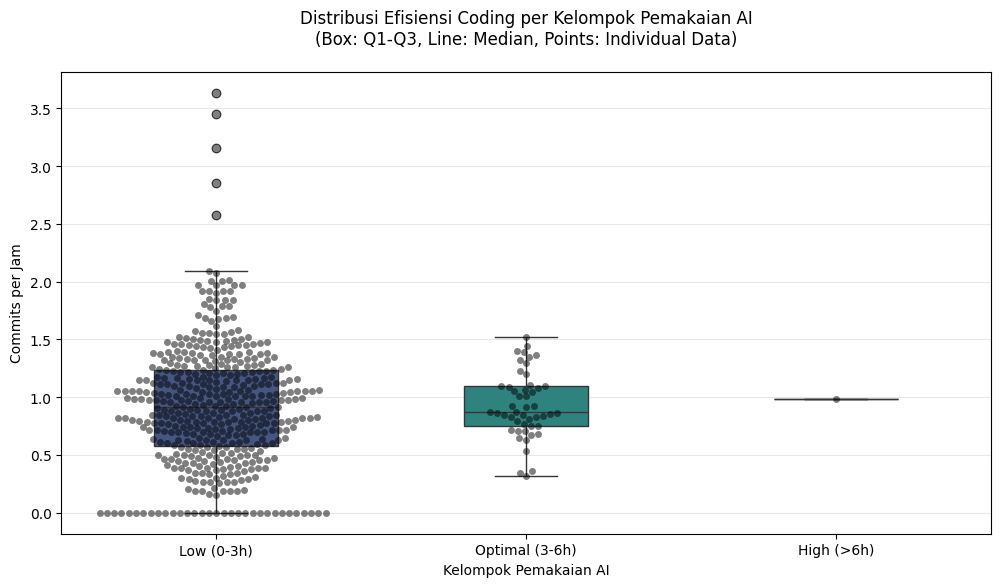

Statistik Deskriptif:
---------------------

Group: Low (0-3h)
Jumlah observasi (N): 448
Rata-rata: 0.92
Standar deviasi: 0.53
Minimum: 0.00
Median: 0.91
Maksimum: 3.64

Group: Optimal (3-6h)
Jumlah observasi (N): 49
Rata-rata: 0.93
Standar deviasi: 0.28
Minimum: 0.32
Median: 0.87
Maksimum: 1.52

Group: High (>6h)
Jumlah observasi (N): 1
Rata-rata: 0.99
Standar deviasi: nan
Minimum: 0.99
Median: 0.99
Maksimum: 0.99


In [105]:
# Data Preparation
df['ai_usage_group'] = pd.cut(df['ai_usage_hours'], 
                            bins=[0,3,6,24],
                            labels=['Low (0-3h)', 'Optimal (3-6h)', 'High (>6h)'])

df['coding_efficiency'] = df['commits'] / df['hours_coding']

# Handle potential division by zero
df['coding_efficiency'] = df['coding_efficiency'].replace([np.inf, -np.inf], np.nan)

# Remove groups with insufficient data (less than 2 observations)
group_counts = df['ai_usage_group'].value_counts()
valid_groups = group_counts[group_counts >= 1].index
df_filtered = df[df['ai_usage_group'].isin(valid_groups)]

# Visualisation
plt.figure(figsize=(12, 6))

# Create boxplot with proper hue assignment
box = sns.boxplot(
    data=df_filtered,
    x="ai_usage_group",
    y="coding_efficiency",
    hue="ai_usage_group", 
    palette="viridis",
    width=0.4,
    order=valid_groups,
    dodge=False, 
    legend=False 
)

# Add swarmplot
swarm = sns.swarmplot(
    data=df_filtered,
    x="ai_usage_group",
    y="coding_efficiency",
    color="black",
    alpha=0.5,
    size=5,
    order=valid_groups
)

plt.title("Distribusi Efisiensi Coding per Kelompok Pemakaian AI\n(Box: Q1-Q3, Line: Median, Points: Individual Data)", pad=20)
plt.xlabel("Kelompok Pemakaian AI")
plt.ylabel("Commits per Jam")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Descriptive Statistics
print("Statistik Deskriptif:")
print("---------------------")
for group in valid_groups:
    group_data = df_filtered[df_filtered['ai_usage_group'] == group]['coding_efficiency']
    print(f"\nGroup: {group}")
    print(f"Jumlah observasi (N): {len(group_data)}")
    print(f"Rata-rata: {group_data.mean():.2f}")
    print(f"Standar deviasi: {group_data.std():.2f}")
    print(f"Minimum: {group_data.min():.2f}")
    print(f"Median: {group_data.median():.2f}")
    print(f"Maksimum: {group_data.max():.2f}")

#### 3. Menganalisis penggunaan AI dalam meningkatkan produktifitas developer berdasarkan tingkat gangguan

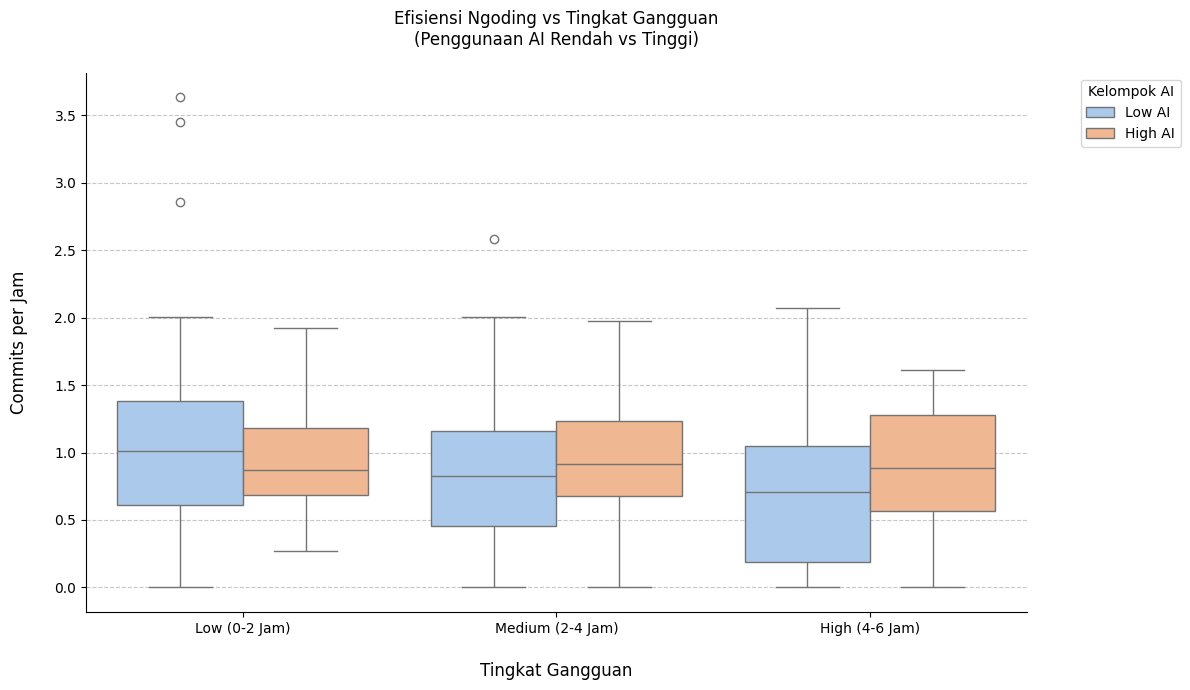

Statistik Deskriptif:
---------------------

TINGKAT GANGGUAN: Low (0-2 Jam)
--------------------------------------------------
High AI (N=98): 0.93 ± 0.38 commits/jam
Low AI (N=99): 1.04 ± 0.65 commits/jam
Perbedaan: -0.11 commits/jam
Effect size (Cohen's d): -0.20
Interpretasi: Perbedaan kecil


TINGKAT GANGGUAN: Medium (2-4 Jam)
--------------------------------------------------
High AI (N=94): 0.93 ± 0.41 commits/jam
Low AI (N=99): 0.86 ± 0.53 commits/jam
Perbedaan: 0.07 commits/jam
Effect size (Cohen's d): 0.15
Interpretasi: Perbedaan sangat kecil


TINGKAT GANGGUAN: High (4-6 Jam)
--------------------------------------------------
High AI (N=43): 0.88 ± 0.45 commits/jam
Low AI (N=29): 0.70 ± 0.57 commits/jam
Perbedaan: 0.18 commits/jam
Effect size (Cohen's d): 0.35
Interpretasi: Perbedaan kecil




In [108]:
# Pastikan tipe data numerik
df["ai_usage_hours"] = pd.to_numeric(df["ai_usage_hours"], errors='coerce')
df["distractions"] = pd.to_numeric(df["distractions"], errors='coerce')
df["coding_efficiency"] = pd.to_numeric(df["coding_efficiency"], errors='coerce')

# Hapus baris dengan nilai hilang
df = df.dropna(subset=["ai_usage_hours", "distractions", "coding_efficiency"])

# Hitung median AI usage
median_ai = df["ai_usage_hours"].median()

# Buat kolom kategori AI usage
df["ai_usage_group"] = np.where(
    df["ai_usage_hours"] > median_ai, 
    "High AI", 
    "Low AI"
)

# Buat kolom tingkat gangguan
df["distraction_level"] = pd.cut(df["distractions"], 
                                bins=[0, 2, 4, 6], 
                                labels=["Low (0-2 Jam)", "Medium (2-4 Jam)", "High (4-6 Jam)"])

# Plot
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df,
    x="distraction_level",
    y="coding_efficiency",
    hue="ai_usage_group",
    palette="pastel",
    order=["Low (0-2 Jam)", "Medium (2-4 Jam)", "High (4-6 Jam)"]
)

plt.title("Efisiensi Ngoding vs Tingkat Gangguan\n(Penggunaan AI Rendah vs Tinggi)", pad=20)
plt.xlabel("\nTingkat Gangguan", fontsize=12)
plt.ylabel("Commits per Jam\n", fontsize=12)
plt.legend(title="Kelompok AI", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()

# Descriptive Statistics
print("Statistik Deskriptif:")
print("---------------------")
print("")

for level in ["Low (0-2 Jam)", "Medium (2-4 Jam)", "High (4-6 Jam)"]:
    high_ai = df[(df["distraction_level"] == level) & (df["ai_usage_group"] == "High AI")]["coding_efficiency"]
    low_ai = df[(df["distraction_level"] == level) & (df["ai_usage_group"] == "Low AI")]["coding_efficiency"]
    
    # Hitung statistik deskriptif
    n_high = len(high_ai)
    n_low = len(low_ai)
    mean_high = high_ai.mean()
    mean_low = low_ai.mean()
    std_high = high_ai.std()
    std_low = low_ai.std()
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((n_high-1)*std_high**2 + (n_low-1)*std_low**2) / (n_high + n_low - 2))
    d = (mean_high - mean_low) / pooled_std
    
    print(f"TINGKAT GANGGUAN: {level}")
    print("-"*50)
    print(f"High AI (N={n_high}): {mean_high:.2f} ± {std_high:.2f} commits/jam")
    print(f"Low AI (N={n_low}): {mean_low:.2f} ± {std_low:.2f} commits/jam")
    print(f"Perbedaan: {mean_high - mean_low:.2f} commits/jam")
    print(f"Effect size (Cohen's d): {d:.2f}")
    
    # Interpretasi effect size
    if abs(d) < 0.2:
        size_interp = "sangat kecil"
    elif abs(d) < 0.5:
        size_interp = "kecil"
    elif abs(d) < 0.8:
        size_interp = "sedang"
    else:
        size_interp = "besar"
    
    print(f"Interpretasi: Perbedaan {size_interp}")
    print("\n" + "="*50 + "\n")

In [110]:
# Using 'commits' as a proxy for productivity
corr, p_value = pearsonr(df['ai_usage_hours'], df['commits'])
print(f"Correlation (AI Usage vs. Commits): {corr:.2f}, p-value: {p_value:.3f}")

# Using 'task_success' as a proxy
corr, p_value = pearsonr(df['ai_usage_hours'], df['task_success'])
print(f"Correlation (AI Usage vs. Task Success): {corr:.2f}, p-value: {p_value:.3f}")

# Using 'bugs_reported' (inverse relationship)
corr, p_value = pearsonr(df['ai_usage_hours'], df['bugs_reported'])
print(f"Correlation (AI Usage vs. Bugs): {corr:.2f}, p-value: {p_value:.3f}")

Correlation (AI Usage vs. Commits): 0.36, p-value: 0.000
Correlation (AI Usage vs. Task Success): 0.24, p-value: 0.000
Correlation (AI Usage vs. Bugs): 0.11, p-value: 0.012
